# Dataset Creation
---
Questo notebook contiene il codice per scaricare e preparare dati finanziari.


## Import Libraries and Set Style


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
%matplotlib inline
from sklearn.linear_model import LinearRegression
import yfinance as yf
import random

## Financial Data


[*********************100%%**********************]  1 of 1 completed


Number of non-missing values: 2595
[[2.9849999 ]
 [2.99499989]
 [2.96099997]
 ...
 [4.59800005]
 [4.65199995]
 [4.70599985]]


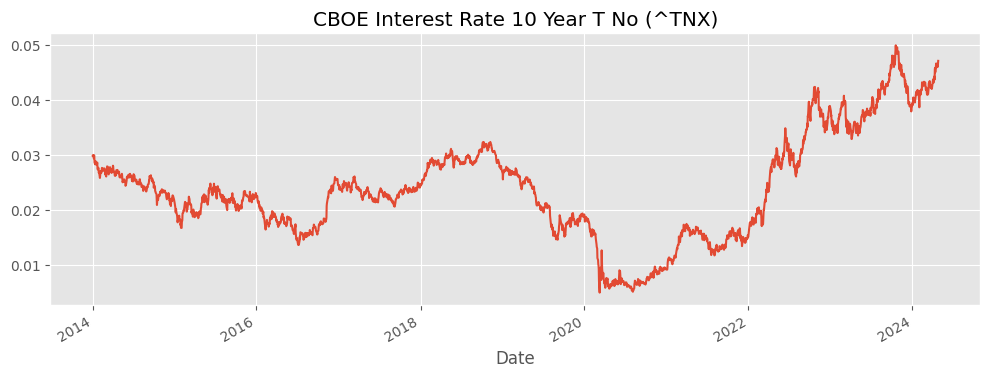

In [3]:
# Real Data
symbol = "^TNX"
start_date = "2014-01-01"
end_date = "2024-04-26"
data = yf.download(symbol, start=start_date, end=end_date)

# Extract adjusted closing prices and remove missing values
rate_df = data[['Open', 'High', 'Low', 'Adj Close']].dropna()

# Plotting the chart
(rate_df['Adj Close']/100).plot(figsize=(12,4), title='CBOE Interest Rate 10 Year T No (^TNX)')

# Get the length of non-missing values
n = len(rate_df)
print("Number of non-missing values:", n)

rate = rate_df['Adj Close']
ratek = np.array(rate)
ratekplus1 = np.concatenate((ratek[1:], [0]))
real_rate = ratek.reshape(-1, 1)

# Visualization 
print(real_rate)

## Vasicek Model Explanation


The stochastic differential equation of the Vasicek model is:

$$dV_t = \kappa (\theta - V_t) \, dt + \sigma \sqrt{dt} \, dW_t $$

Numerical Solution with Euler Integration:

$$ V_{t+\Delta t} = V_t + \kappa (\theta - V_t) \Delta t + \sigma \sqrt{\Delta t} \, W_t $$

In [4]:
# Parameters
real_rate
last_rate=real_rate[-1].astype(np.float64)
last_rate = real_rate[-1].astype(np.float64).item()
random.seed(123456) #seed
r0 = last_rate/100 # Initial interest rate
kappa = 0.1  # Reversion speed
theta = 0.05  # mean reversion
sigma = 0.2  # interest rate volatility
T = 1  # final time
N = 1023 # Number of time intervals
dt = T / N  # Time step
num_paths = 10000 # Number of paths to simulate

#Datframe Creation
data = {'Time': np.linspace(0, T, N+1)}  # add a column for the time
for i in range(num_paths):
    rs = np.zeros(N + 1)
    rs[0] = r0
    for t in range(1, N + 1):
        dW = np.random.normal(loc=0, scale=np.sqrt(dt))
        rs[t] = rs[t - 1] + kappa * (theta - rs[t - 1]) * dt + sigma * np.sqrt(dt) * dW
    data[f'Simulation_{i+1}'] = rs


df = pd.DataFrame(data)

# Add the new row r0
new_row = {'Time': 0}
for i in range(num_paths):
    new_row[f'Simulation_{i+1}'] = r0

# Dataframe with the new row r0

df = df.drop(columns=['Time'])

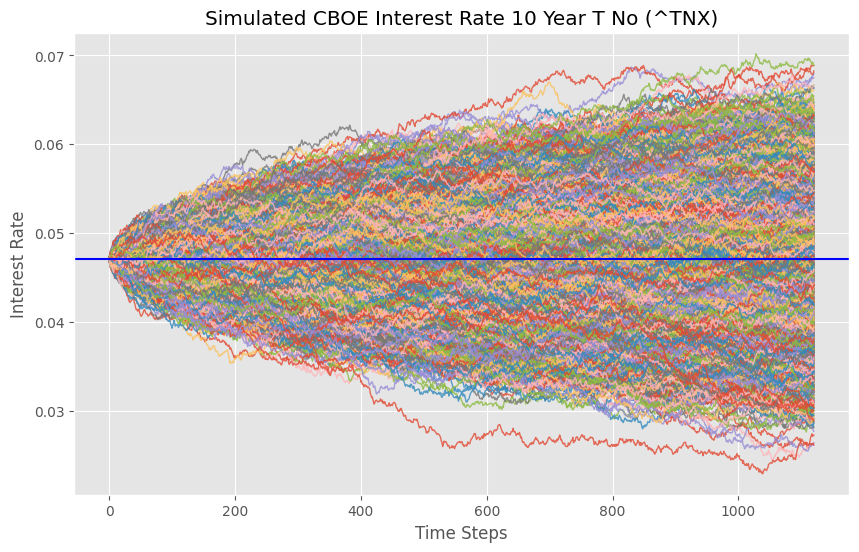

In [5]:
# Visualization
plt.figure(figsize=(10, 6))

# Plot each simulated path
for i in range(num_paths):
    plt.plot(df.index, df[f'Simulation_{i+1}'], lw=1, alpha=0.8)

plt.title('Simulated CBOE Interest Rate 10 Year T No (^TNX)')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.axhline(y=r0, color='b', linestyle='-')


plt.show()

In [5]:
#PAYOFF

K=r0 #Strike Price
S_T=df.iloc[-1]
#print(S_T)
S_T_mean = df.iloc[-1].mean()
print(S_T_mean)

payoff = np.zeros(num_paths)
for i in range(num_paths):
    if S_T[i] > K:  # Check if the final price is greater than the strike price
        payoff[i] = 1  # If yes, the option is in-the-money, so the payoff is 1
    else:
        payoff[i] = 0  # Otherwise, the option is out-of-the-money, so the payoff is 0
print(payoff)
print(payoff.sum())
print(payoff.std())

0.04733339395781674
[0. 0. 1. ... 1. 0. 1.]
5208.0
0.4995671726604942


In [6]:
# DataFrame structure
df.loc['Payoff'] = payoff
print(df)

        Simulation_1  Simulation_2  Simulation_3  Simulation_4  Simulation_5  \
0           0.047060      0.047060      0.047060      0.047060      0.047060   
1           0.047069      0.047116      0.046801      0.047552      0.046909   
2           0.047009      0.047254      0.046590      0.047552      0.046732   
3           0.046852      0.047148      0.046774      0.047641      0.046665   
4           0.046831      0.047242      0.046911      0.048027      0.046734   
...              ...           ...           ...           ...           ...   
1020        0.044248      0.034652      0.049610      0.053541      0.047154   
1021        0.043999      0.034895      0.049725      0.053399      0.046654   
1022        0.044296      0.034641      0.049636      0.053313      0.046902   
1023        0.044541      0.034469      0.049181      0.053389      0.046832   
Payoff      0.000000      0.000000      1.000000      1.000000      0.000000   

        Simulation_6  Simulation_7  Sim

In [7]:
print(df)
df_invertito = df.transpose()
print(df_invertito)
df_invertito['Payoff'] = (df_invertito.iloc[:, -1] > df_invertito.iloc[:, 0]).astype(int)
nuovi_nomi_colonne = {col: f"r{col}" for col in df_invertito.columns}
df_invertito = df_invertito.rename(columns=nuovi_nomi_colonne)

print(df_invertito)

        Simulation_1  Simulation_2  Simulation_3  Simulation_4  Simulation_5  \
0           0.047060      0.047060      0.047060      0.047060      0.047060   
1           0.047069      0.047116      0.046801      0.047552      0.046909   
2           0.047009      0.047254      0.046590      0.047552      0.046732   
3           0.046852      0.047148      0.046774      0.047641      0.046665   
4           0.046831      0.047242      0.046911      0.048027      0.046734   
...              ...           ...           ...           ...           ...   
1020        0.044248      0.034652      0.049610      0.053541      0.047154   
1021        0.043999      0.034895      0.049725      0.053399      0.046654   
1022        0.044296      0.034641      0.049636      0.053313      0.046902   
1023        0.044541      0.034469      0.049181      0.053389      0.046832   
Payoff      0.000000      0.000000      1.000000      1.000000      0.000000   

        Simulation_6  Simulation_7  Sim

## Saving Data


In [9]:
# Specify the path where you want to save the CSV file
path = "/media/neurone-pc6/Volume/Michele/Prog_GAF_Michele/pythonProject/data/Vasiceksimulation_23_07.csv"

# Save the DataFrame as a CSV file at the specified path
new_var =df_invertito.to_csv(path, index=False)